In [1]:
import math
import os
import torch
import torch.nn as nn
from collections import OrderedDict
from torchvision  import transforms as TR
from pytorch3d.structures import Meshes
from collections import OrderedDict
from src.config import get_parser
from src.utilities.util import (
    grid_to_list,
    list_to_grid,
    make_faces,
)
from src.utilities.alignment import align
from src.render.mesh_points_renderer import MeshPointsRenderer
from src.utilities.operators import mean_distance
torch.set_printoptions(precision=4, sci_mode=False)

In [2]:
device = torch.device('cuda')

d = torch.load('./data/npz/ada_wong_resident_evil_256.pth')
vertices = d['vertices'][None].to(device)
normals = d['normals'][None].to(device)

vertices.shape, normals.shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 3, 256, 256]))

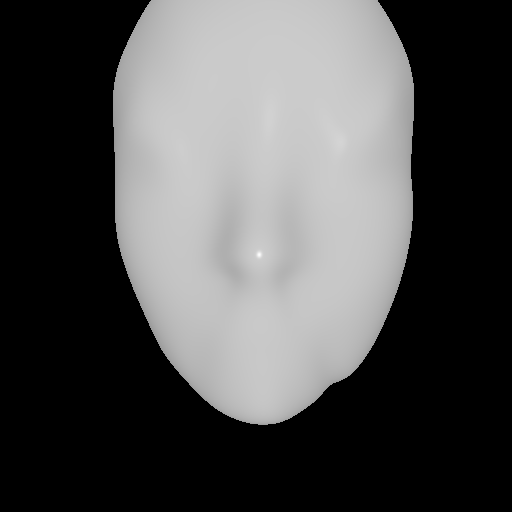

In [3]:
config = get_parser().parse_args(args=[])
config.fast_image_size = 512
config.fast_baseline_size = 256
config.viewpoint_distance = 1.25
R = MeshPointsRenderer(config).to(device)
R
colors = torch.ones_like(vertices)
renders = R(vertices.detach(), colors.detach())
TR.ToPILImage()(renders[0])

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 64, 64]) torch.Size([1, 3, 64, 64])


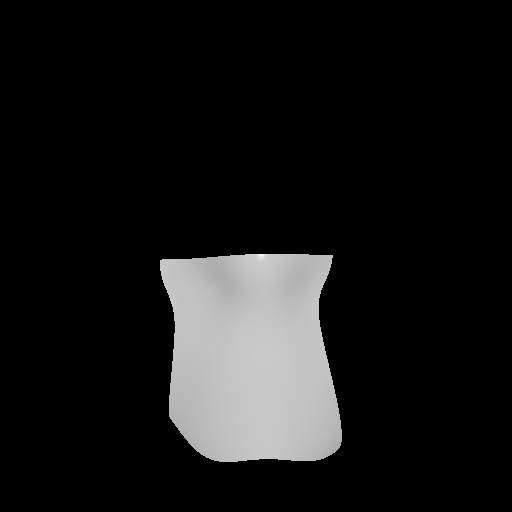

In [4]:
print(vertices.shape, normals.shape)
sz = 64
sh = 90
sv = 64
patch_vertex = vertices[:, :, sv:sv+sz, sh:sh+sz]
patch_normal = normals[:, :, sv:sv+sz, sh:sh+sz]
print(patch_vertex.shape, patch_normal.shape)

config.fast_image_size = 512
config.fast_baseline_size = patch_vertex.size(-1)
config.viewpoint_distance = 1.0
R = MeshPointsRenderer(config).to(device)
R
colors = torch.ones_like(patch_vertex)
renders = R(patch_vertex, colors.detach())
TR.ToPILImage()(renders[0])

torch.Size([1, 3, 64, 64]) torch.Size([1, 3, 64, 64])


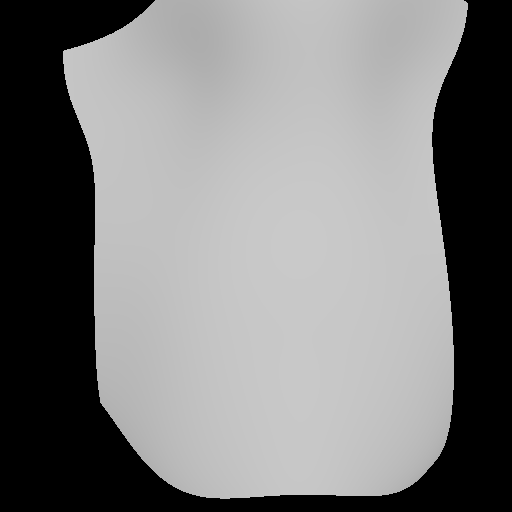

In [5]:
print(patch_vertex.shape, patch_normal.shape)
p_v, p_n =  align(grid_to_list(patch_vertex), grid_to_list(patch_normal), rotate=False)
p_v, p_n = list_to_grid(p_v), list_to_grid(p_n)


config.fast_image_size = 512
config.fast_baseline_size = patch_vertex.size(-1)
config.viewpoint_distance = 0.8
R = MeshPointsRenderer(config).to(device)
renders = R(p_v, colors.detach())
TR.ToPILImage()(renders[0])

In [9]:
from types import SimpleNamespace
from src.models.normal_generator import Generator

sn = SimpleNamespace(fast_generator_channels=[ 128, 128, 256, 256])

G = Generator(sn).to(device)
G

Generator(
  (points): SinGenerator(
    (trunk): Sequential(
      (head): ConvBlock(
        (conv): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (lrelu): LeakyReLU(negative_slope=0.2)
      )
      (main): Sequential(
        (b0): ConvBlock(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.2)
        )
        (b1): ConvBlock(
          (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.2)
        )
        (b2): ConvBlock(
          (conv): Conv2d(256, 256, kernel_size=(3, 3),

torch.Size([1, 3, 64, 64]) torch.Size([1, 3, 64, 64])


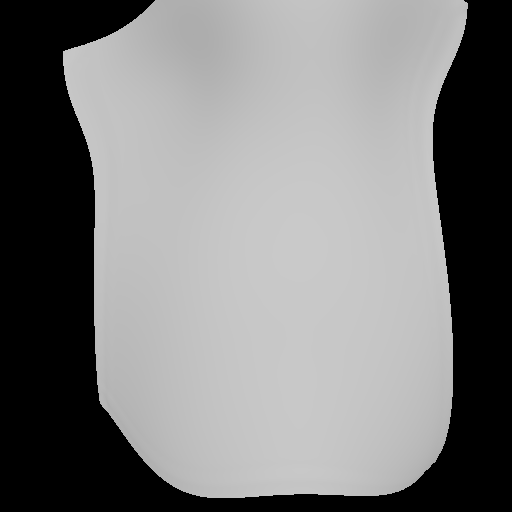

In [11]:
pts, clr = G(patch_vertex, patch_normal)


print(patch_vertex.shape, patch_normal.shape)
p_v, p_n =  align(grid_to_list(pts), grid_to_list(patch_normal), rotate=False)
p_v, p_n = list_to_grid(p_v), list_to_grid(p_n)


config.fast_image_size = 512
config.fast_baseline_size = patch_vertex.size(-1)
config.viewpoint_distance = 0.8
R = MeshPointsRenderer(config).to(device)
renders = R(p_v, colors.detach())
TR.ToPILImage()(renders[0])

In [15]:
(pts -patch_vertex).abs().mean()

tensor(    0.0001, device='cuda:0', grad_fn=<MeanBackward0>)